In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_roc_curve
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from joblib import dump

In [2]:
#Read in the data
df = pd.read_csv("../Logged-Matrix-Data.csv")
X = df[['Bluetooth-2','Accelerometer-1', 'Accelerometer-2', 'Accelerometer-3', 'Gyroscope-1', 'Gyroscope-2', 'Gyroscope-3']]
df[['Distance']] = df[['Distance']].values > 6
y = df[['Distance']]

#Split the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y)
#Series where metrics are stored
s = pd.Series(index = ["id", "validation score", "auc", "f-measure", "precision", "recall"])

C:\Users\swang\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


0.838896671658374


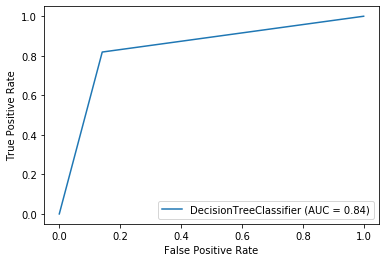

In [3]:
#Call the model
model = DecisionTreeClassifier()
#Train the model
model.fit(X_train, y_train)
#Test the model
y_hats = model.predict(X_test)
#Collect and print model metrics
plot_roc_curve(model,X_test, y_test['Distance'])
s["validation score"] = roc_auc_score(y_test['Distance'], y_hats)
print(s["validation score"])

0.5547945205479452
0.5578231292517007
0.5540540540540541
0.5616438356164384


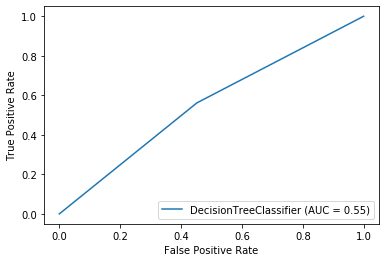

In [4]:
#Set the IDs for the model
model_name = "Decision_Tree"
dateId = datetime.now().strftime('%m_%d_%Y_%H_%M_%S')
#Read in the pi data for validation
df_test = pd.read_csv("../Pi_Distance_Data.csv")
X_pi = df_test[['RSSI','ax','ay','az','gx','gy','gz']]
df_test[['Distance']] = df_test[['Distance']].values > 6
y_pi = df_test[['Distance']]
y_hats = model.predict(X_pi)
#Collect and print the model metrics
s["auc"] = roc_auc_score(y_pi['Distance'], y_hats)
print(s["auc"])
plot_roc_curve(model,X_pi, y_pi['Distance'])
s["id"] = dateId
s["f-measure"] = f1_score(y_pi['Distance'], y_hats)
print(s["f-measure"])
s["precision"] = precision_score(y_pi['Distance'], y_hats)
print(s["precision"])
s["recall"] = recall_score(y_pi['Distance'], y_hats)
print(s["recall"])
#Append this data to the CSV
pd.DataFrame(s).T.to_csv(model_name+".csv", mode ="a", index=False, header = False)
#Pickle the model
dump(model, "saved/" + model_name+'/' + dateId + "_" + str(s["auc"]) + '.joblib')

0.8650000000000001
0.8336586423769248
0.8625770416024654
0.8519258720930233


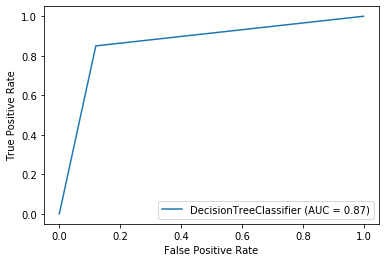

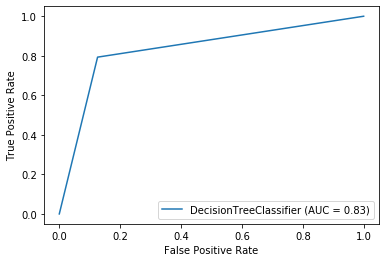

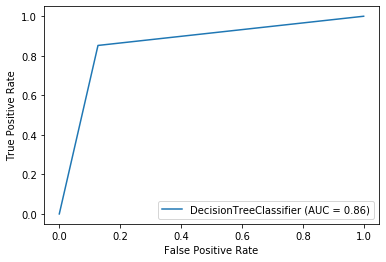

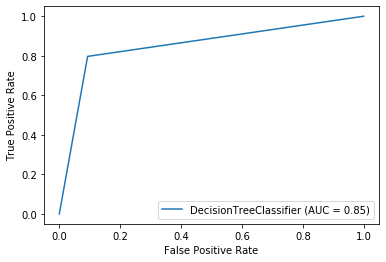

In [5]:
from joblib import dump, load
dump(model, "saved/" + model_name+'/' + dateId + "_" + str(s["auc"]) + '.joblib')

sizes = [1,3,5,7,10]
current = 1
for i in sizes:
    if i == current:
        continue
    df = pd.read_csv("../Logged-Matrix-Data"+str(i)+".csv")
    X_test = df[['Bluetooth-2','Accelerometer-1', 'Accelerometer-2', 'Accelerometer-3', 'Gyroscope-1', 'Gyroscope-2', 'Gyroscope-3']]
    df[['Distance']] = df[['Distance']].values > 6
    y_test = df[['Distance']]
    y_hats = model.predict(X_test)
    print(roc_auc_score(y_test['Distance'], y_hats))
    plot_roc_curve(model,X_test, y_test['Distance'])

In [6]:
#Look and graph feature importances
from collections import defaultdict
d = defaultdict(int)
for idx in np.argsort(-model.feature_importances_):
    print(X.columns.values[idx], model.feature_importances_[idx])
    d["raspberry_pi_" + X.columns.values[idx].split("-")[0] + "_sensor"] += model.feature_importances_[idx]
print(d.keys())

Accelerometer-3 0.29426540012262037
Accelerometer-2 0.22339768281469813
Bluetooth-2 0.19177900255237562
Accelerometer-1 0.11499541977660879
Gyroscope-1 0.07428249648517564
Gyroscope-2 0.052428465217207426
Gyroscope-3 0.04885153303131387
dict_keys(['raspberry_pi_Accelerometer_sensor', 'raspberry_pi_Bluetooth_sensor', 'raspberry_pi_Gyroscope_sensor'])
